In [1]:
import argparse
import os
import glob

#load data
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms, utils, datasets

from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import SYNet
import time
import copy
import csv


In [2]:
concrete_cement_type = [1.0, 0.0, 0.0, 0.0, 0.0]
healthy_metal_type = [0.0, 1.0, 0.0, 0.0, 0.0]
incomplete_type = [0.0, 0.0, 1.0, 0.0, 0.0]
irregular_metal_type = [0.0, 0.0, 0.0, 1.0, 0.0]
other_type = [0.0, 0.0, 0.0, 0.0, 1.0]

In [185]:
concrete_cement_images = glob.glob('./training/unmasked/concrete_cement/*.png')
a= [concrete_cement_type] * len(concrete_cement_images)

healthy_metal_images = glob.glob('./training/masked/healthy_metal/*.png')
b=[healthy_metal_type] * len(healthy_metal_images)

incomplete_images = glob.glob('./training/masked/incomplete/*.png')
c=[incomplete_type] * len(incomplete_images)

irregular_metal_images = glob.glob('./training/masked/irregular_metal/*.png')
d=[irregular_metal_type]  * len(irregular_metal_images)

other_images = glob.glob('./training/masked/other/*.png')
e=[other_type] * len(other_images)

train_images = [concrete_cement_images, healthy_metal_images, incomplete_images, irregular_metal_images, other_images]
train_images_labels = [a,b,c,d,e]

train_images = [item for sublist in train_images for item in sublist]
train_images_labels = [item for sublist in train_images_labels for item in sublist]

test_images = list(pd.read_csv("submission_format.csv",index_col=0).index.values)
test_images = ['./testing/masked/' + str(i) + '.png' for i in test_images]
#test_images = glob.glob('./testing/masked/*.png')

In [186]:
test_images[0]

'./testing/masked/7a4d630a.png'

In [5]:
class RoofDataset(Dataset):
    def __init__(self, train_image_paths, train_images_labels,transform=None):
        self.image_paths = train_image_paths
        self.image_labels = train_images_labels
        self.transform=transform
        
    def __getitem__(self, index):
        roof_image = Image.open(self.image_paths[index])
        roof_image = roof_image.convert('RGB')
        plt.imshow(roof_image)
        if self.transform is not None:
            roof_image = self.transform(roof_image)
        
        material_type = torch.LongTensor(self.image_labels[index])
        return roof_image, material_type    
    
    def __len__(self):
        return len(self.image_paths)

In [187]:
class RoofTestDataset(Dataset):
    def __init__(self, image_paths,transform=None):
        self.image_paths = image_paths
        self.transform=transform
        
    def __getitem__(self, index):
        roof_id = self.image_paths[index].replace('./testing/masked/','').replace('.png','')
        #print("Replaced:", roof_id)
        roof_image = Image.open(self.image_paths[index])
        roof_image = roof_image.convert('RGB')
        plt.imshow(roof_image)
        if self.transform is not None:
            roof_image = self.transform(roof_image)
        return roof_image, roof_id
    
    def __len__(self):
        return len(self.image_paths)

In [188]:
transformations = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
train_dataset = RoofDataset(train_images, train_images_labels,transformations)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0
                         )

test_dataset = RoofTestDataset(test_images, transformations)
test_loader = DataLoader(test_dataset,
                        batch_size = 1,
                        num_workers = 0)

In [8]:
model = SYNet.Baseline()
model.cuda()
raise
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
#criterion = torch.nn.functional.softmax(output)
criterion = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(async=True), target.cuda(async=True) # On GPU
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        _, idx = torch.max(target,1)
        loss = criterion(output, idx)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))

for epoch in range(1,6):
    train(epoch)

RuntimeError: No active exception to reraise

### torch.save(model.state_dict(), './models/resnet18_5_0.0001.pt')

In [9]:
model.load_state_dict(torch.load('./models/resnet18_5_0.0001.pt'))

<All keys matched successfully>

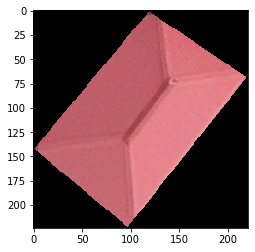

In [189]:
for p in model.parameters():
    if p.grad is not None:
        del p.grad
torch.cuda.empty_cache()

test_id = []
test_label = []
list_from_labelTensor = []

def test():
    model.eval()
    predictions = []
    for data, roof_id in test_loader:
        replaced_roof_id = roof_id[0]
        test_id.append(replaced_roof_id)
       # print(replaced_roof_id)
        data = data.cuda(async=True) # On GPU
        output = model(data)
        list_from_labelTensor = torch.nn.functional.softmax(output, dim=1).tolist()
        #print(replaced_roof_id, list_from_labelTensor)
        test_label.append(list_from_labelTensor)
        
        
test()
#print(len(test_id), len(test_label))


In [190]:
print(len(test_id), len(test_label))


7325 7325


In [191]:
submission_dict = {}
submission_dict['id'] = []
submission_dict['concrete_cement'] = [] 
submission_dict['healthy_metal'] = []
submission_dict['incomplete'] = []
submission_dict['irregular_metal'] = []
submission_dict['other'] = []

for i, j in zip(test_id, test_label):
    submission_dict['id'].append(i)
    submission_dict['concrete_cement'].append(j[0][0])
    submission_dict['healthy_metal'].append(j[0][1])
    submission_dict['incomplete'].append(j[0][2])
    submission_dict['irregular_metal'].append(j[0][3])
    submission_dict['other'].append(j[0][4])
    

In [192]:
pd.DataFrame(submission_dict).to_csv("submission_result.csv")
sub_df = pd.read_csv("submission_result.csv",index_col=0)

In [193]:
sub_df

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.001492,0.955091,0.005608,0.034917,0.002892
1,7a4bbbd6,0.000986,0.958111,0.006746,0.031498,0.002660
2,7a4ac744,0.002301,0.854989,0.012256,0.123426,0.007028
3,7a4881fa,0.007506,0.547462,0.040768,0.392216,0.012048
4,7a4aa4a8,0.007797,0.760493,0.040571,0.177513,0.013625
...,...,...,...,...,...,...
7320,7a4f3ff4,0.003415,0.450099,0.031461,0.499319,0.015707
7321,7a4fc578,0.006671,0.907496,0.017696,0.057109,0.011028
7322,7a4ac7b2,0.001344,0.898759,0.009942,0.085038,0.004918
7323,7a47e25e,0.019787,0.431513,0.070791,0.460130,0.017779


In [194]:
sub_df.to_csv("./submission_result.csv", index = False)